In [2]:
import torch
import os
from torch import nn
from torch.optim import Adam
import torchvision
from IPython import display
from matplotlib.pyplot import imshow
import numpy as np
from PIL import ImageDraw
from PIL import ImageFont

In [3]:
from dataset import MemeCaptionDataset
from captionmodel import EncoderCNN, DecoderRNN
from torchgan.models import DCGANGenerator
from infer_caption import pred_vec_to_text

from settings import caption_batch_size, workers

to_pil = torchvision.transforms.ToPILImage(mode='RGB')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GAN_PARAMS_TO_LOAD = 'trained_model.model'
ENCODER_PARAMS_TO_LOAD = 'encoder-440.pth'
DECODER_PARAMS_TO_LOAD = 'decoder-440.pth'

GAN_CKPT_PATH = f'./model/{GAN_PARAMS_TO_LOAD}'
ENCODER_CKPT_PATH = f'./caption-model-ckpts/{ENCODER_PARAMS_TO_LOAD}'
DECODER_CKPT_PATH = f'./caption-model-ckpts/{DECODER_PARAMS_TO_LOAD}'

In [5]:
# Load the meme background generator

generator_state_dict = torch.load(
    GAN_CKPT_PATH,
    map_location=torch.device(device)
)['generator']

generator = DCGANGenerator(
    encoding_dims=100,
    out_size=64,
    out_channels=3,
    step_channels=64,
    nonlinearity=nn.LeakyReLU(0.2),
    last_nonlinearity=nn.Tanh(),
).to(device)

generator.load_state_dict(
    state_dict=generator_state_dict
)


<All keys matched successfully>

In [6]:
# Load the CNN Encoder and RNN Decoder
dataset = MemeCaptionDataset()

data_loader = iter(torch.utils.data.DataLoader(
    dataset,
    batch_size=caption_batch_size,
    shuffle=True, 
    num_workers=workers
))

vocab_size = len(dataset.itos)

encoder = EncoderCNN().to(device)
decoder = DecoderRNN(
    embed_size=1024, 
    hidden_size=1024, 
    vocab_size=vocab_size
).to(device)

encoder.load_state_dict(
    torch.load(ENCODER_CKPT_PATH, map_location=torch.device(device))
)

decoder.load_state_dict(
    torch.load(DECODER_CKPT_PATH, map_location=torch.device(device))
)
encoder.eval()
decoder.eval()

DecoderRNN(
  (lstm_cell): LSTMCell(1024, 1024)
  (fc_out): Linear(in_features=1024, out_features=28676, bias=True)
  (embed): Embedding(28676, 1024)
  (softmax): Softmax(dim=1)
)

torch.Size([1, 15, 28676])
torch.Size([1, 15])
tensor([[28675,     6,    10,     9,     0,  3393,     0,     1,    36,   423,
             0,     1,     1,   126,     4]])


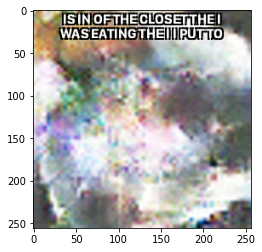

In [8]:
from infer_full import create_meme


meme = create_meme(
    encoder=encoder,
    decoder=decoder,
    generator=generator,
    data_loader=data_loader,
    device=device,
    dataset=dataset
)

imshow(np.asarray(meme))